In [3]:
import numpy as np
import pandas as pd 
import os
import torch
from torchvision import datasets, transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [6]:
from PIL import Image

class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Получаем список папок (классов)
        self.classes = sorted(os.listdir(data_dir))
        
        # Создаем словарь, где ключ - это название класса, а значение - это его порядковый номер (метка)
        self.class_to_label = {class_name: i for i, class_name in enumerate(self.classes)}
        
        # Получаем список всех файлов с изображениями и их соответствующие метки
        self.samples = self.load_samples()
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def load_samples(self):
        samples = []
        
        for class_ in self.classes:
            class_path = os.path.join(self.data_dir, class_)
            image_files = os.listdir(class_path)
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                samples.append((image_path, self.class_to_label[class_]))
        return samples   

In [7]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.classes = ['all', 'heim']

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset1 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0')
dataset2 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1')
dataset3 = datasets.ImageFolder(root='/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2')

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2, dataset3])

In [9]:
from torch.utils.data import random_split
train_ratio = 0.8
train_data, val_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [10]:
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [11]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [13]:
from torchvision import models

resnet = models.resnet101(pretrained=True)
resnet

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 168MB/s]  


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
from torch import nn
import torch.nn.functional as F


class TransferLerningLeukemiaClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        
        res_net101 = models.resnet101(pretrained=True)
        
        for param in res_net101.parameters():
            param.requires_grad = False
        
        in_features = res_net101.fc.in_features
        res_net101.fc = nn.Identity()
        
        self.feature_extractor = res_net101
        
        self.dropout1 = nn.Dropout(0.2)
        self.linear1 = nn.Linear(in_features, num_classes)

        
    
    def forward(self, x):
        out = self.feature_extractor(x)
        
        out = self.dropout1(out)
        
        out = self.linear1(out)
        out = F.relu(out)
        
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TransferLerningLeukemiaClassifier(len(train_data.classes)).to(device)

In [15]:
!pip install -q torchsummary

In [17]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [18]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [19]:
total_cls = [item[1] for item in dataset]
count_all = total_cls.count(0)
count_hem = total_cls.count(1)
print(f'{count_all} {count_hem}')

7272 3389


In [21]:
weight_all = count_hem / (count_all + count_hem)
weight_hem = count_all / (count_all + count_hem)
weights = torch.tensor([weight_all, weight_hem], device=device)

In [22]:
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [23]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=13,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLerningLeukemiaClassifier, opt=Adam(lr=0.000100), epochs=13, device=cuda

Epoch    1  126sec	loss:      0.673	val_loss:      0.672	accuracy_score:      0.605	val_accuracy_score:      0.559	
Epoch    2  125sec	loss:      0.617	val_loss:      0.629	accuracy_score:      0.717	val_accuracy_score:      0.773	
Epoch    3  125sec	loss:      0.578	val_loss:      0.568	accuracy_score:      0.751	val_accuracy_score:      0.807	
Epoch    4  126sec	loss:      0.552	val_loss:      0.536	accuracy_score:      0.777	val_accuracy_score:      0.787	
Epoch    5  126sec	loss:      0.531	val_loss:      0.522	accuracy_score:      0.773	val_accuracy_score:      0.813	
Epoch    6  126sec	loss:       0.52	val_loss:       0.51	accuracy_score:      0.786	val_accuracy_score:      0.811	
Epoch    7  126sec	loss:      0.509	val_loss:      0.499	accuracy_score:      0.789	val_accuracy_score:      0.808	
Epoch    8  126sec	loss:        0.5	val_loss:      0.492	accuracy_score:      0.795	

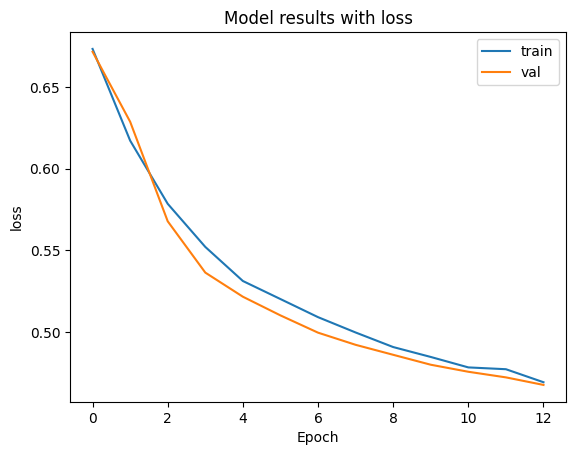

In [24]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

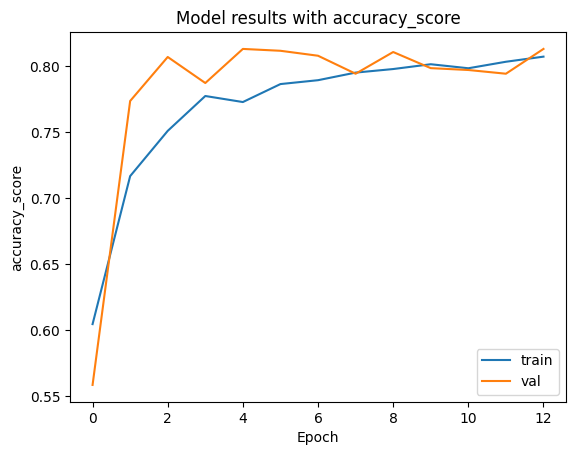

In [25]:
plot_metric(history, 'accuracy_score')

In [1]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')
model.eval()

batch_size = 1024 
loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

y_true = []
y_pred = []

for X_batch, y_batch in loader:
    batch_pred = model.predict(X_batch)
    
    y_true.extend(y_batch.tolist())
    y_pred.extend(batch_pred.argmax(-1).tolist())

display_labels = dataset1.classes

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=display_labels)
plt.xticks(rotation=90)
plt.show()

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.argmax(-1), target_names=dataset1.classes))